In [1]:
import numpy as np
import pandas as pd
import csv
import time

#Scikit-Learn Machine Learning 
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

import pylab as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import metrics

#Seaborn 
pl.style.use('fivethirtyeight')
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

c:\users\shreyansh jain\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\shreyansh jain\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
c:\users\shreyansh jain\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module 

In [2]:
#Read in csv file into pandas dataframe
student_data = pd.read_csv("student-data.csv")
print ("Student data read successfully!")

Student data read successfully!


In [3]:
#return the first 5 rows (all columns)
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [4]:
X_all = student_data.iloc[:,1:-1]
y = student_data['passed']

In [5]:
print(student_data[student_data['passed'] == "no"].shape[0])
print(student_data[student_data['passed'] == "yes"].shape[0])
print(student_data.shape[0])

130
265
395


### Preprocess feature columns

In [6]:
def preprocess_features(X):
    df_preprocess = pd.DataFrame(index=X.index) # output dataframe, initially empty
    # iterate through each column
    for colname, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object: #if data type == object (i.e. non-numeric)
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # If data is non-numeric and consist of more than 2 level
        # convert todummy variables (indicator variables)
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=colname)  
        #join columns to one dataframe
        df_preprocess = df_preprocess.join(col_data)  # collect column(s) in output dataframe
    return df_preprocess

X_all = preprocess_features(X_all)
print("Processed Feature Columns")
X_all.head()

Processed Feature Columns


,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Medu,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,18,0,1,1,0,1,0,4,...,1,0,0,4,3,4,1,1,3,6
1,1,0,17,0,1,1,0,0,1,1,...,1,1,0,5,3,3,1,1,3,4
2,1,0,15,0,1,0,1,0,1,1,...,1,1,0,4,3,2,2,3,3,10
3,1,0,15,0,1,1,0,0,1,4,...,1,1,1,3,2,2,1,1,5,2
4,1,0,16,0,1,1,0,0,1,3,...,1,0,0,4,3,2,1,2,5,4


In [9]:
df = pd.concat([X_all, y], axis = 1)

### Split Data Into Training/Testing Sets

In [10]:
def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 1, test_size=num_test, random_state = None)
    for train, test in sss:
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    return X_train, X_test, y_train, y_test

y = student_data['passed'] # identify target variable
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, 0.25)

print("Training Set: {0:.2f} Samples".format(X_train.shape[0]))
print("Testing Set: {0:.2f} Samples".format(X_test.shape[0]))

Training Set: 296.00 Samples
Testing Set: 99.00 Samples


### Generate Model (Random Forest)

In [11]:
def train_classifier(clf, X_train, y_train):
    start = time.time() #specifty start time
    clf.fit(X_train, y_train) #train model
    end = time.time() #specify end time
    train_clf_time = end - start #total training time
    print("Total Training Time (secs): {:.3f}".format(train_clf_time))
    return train_clf_time 

def predict_labels(clf, features, target):
    start = time.time() #start prediction time
    y_pred = clf.predict(features) #prediction 
    end = time.time() # stop prediction time
    prediction_time = end - start # total prediction time
    print("Prediction Time (secs): {:.3f}".format(prediction_time))
    
    p,r,f,s = precision_recall_fscore_support(target.values,
              y_pred, average='binary', pos_label='yes')
    print("Precision Score: {0:.4f}".format(p))
    print("Recall Score: {0:.4f}".format(r))
    print("F1 Score: {0:.4f}".format(f))
    return(f)

### Train and Predict

In [15]:
clf = RandomForestClassifier()
print("==============================")
print("Model: {}".format(clf.__class__.__name__))
print("==============================")
    
results = []
n_est = [10,50,100,200,300,400,500,600,800,1000]
for trees in n_est:
    
    clf = RandomForestClassifier(n_estimators = trees)
    print("**********************************************************")
    print("**Training**")
    print("Data Size:",len(X_train))

    # Fit model to training data
    train_classifier(clf, X_train, y_train)

    # Predict on training set and compute F1 score
    predict_labels(clf, X_train, y_train)

    #Predict on Testing Data
    print("**********************************************************")
    print("**Testing**")
    print("Data Size:",len(X_test))
    predict_labels(clf, X_test, y_test)
    f1 = predict_labels(clf, X_test, y_test)
    results.append(f1)
   
    print("**********************************************************")

    

Model: RandomForestClassifier
**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.016
Prediction Time (secs): 0.000
Precision Score: 0.9899
Recall Score: 0.9899
F1 Score: 0.9899
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.000
Precision Score: 0.7368
Recall Score: 0.8485
F1 Score: 0.7887
Prediction Time (secs): 0.000
Precision Score: 0.7368
Recall Score: 0.8485
F1 Score: 0.7887
**********************************************************
**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.109
Prediction Time (secs): 0.000
Precision Score: 1.0000
Recall Score: 1.0000
F1 Score: 1.0000
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.016
Precision Score: 0.6977
Recall Score: 0.9091
F1 Score: 0.7895
Prediction Time (secs): 0.000
Precision

Text(0,0.5,'F1 Score')

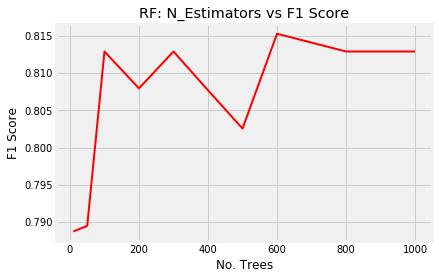

In [16]:
ax = pd.Series(results,n_est).plot(lw=2,color="red",
             title="RF: N_Estimators vs F1 Score")
ax.set_xlabel("No. Trees")
ax.set_ylabel("F1 Score")

In [17]:
df.head()

,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Medu,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,1,0,18,0,1,1,0,1,0,4,...,0,0,4,3,4,1,1,3,6,no
1,1,0,17,0,1,1,0,0,1,1,...,1,0,5,3,3,1,1,3,4,no
2,1,0,15,0,1,0,1,0,1,1,...,1,0,4,3,2,2,3,3,10,yes
3,1,0,15,0,1,1,0,0,1,4,...,1,1,3,2,2,1,1,5,2,yes
4,1,0,16,0,1,1,0,0,1,3,...,0,0,4,3,2,1,2,5,4,yes


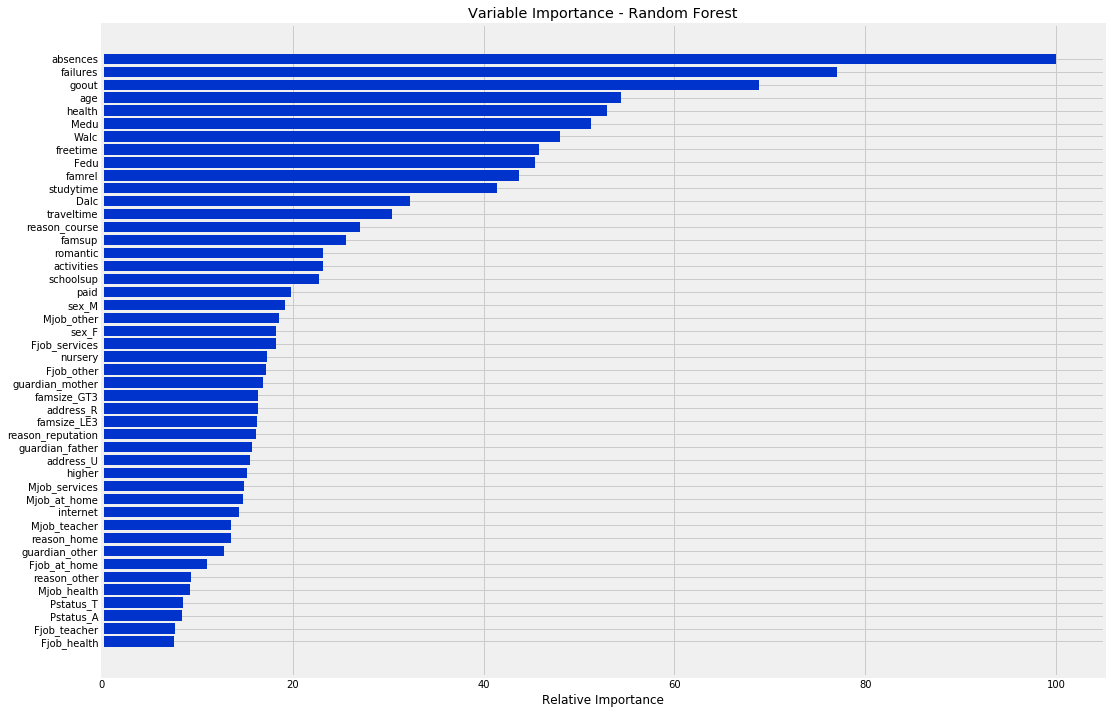

In [18]:
#Feature Selection 
def feature_importance(clf,df):
    
    # Relative Importance (Features)
    clf.fit(X_train,y_train)
    
    # Get Feature Importance from the classifier
    feature_importance = clf.feature_importances_
    
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    # Sort Features and Creat Horizontal Bar Plot
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    pl.figure(figsize=(16, 12))
    pl.barh(pos, feature_importance[sorted_idx], align='center', color='#0033CC')
    pl.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title("Variable Importance - Random Forest")
    pl.show()

feature_importance(clf,df)

### Feature Selection

In [19]:
from sklearn.feature_selection import VarianceThreshold
 
def get_low_variance(X_all,threshold):
   
    selector = VarianceThreshold()
    selector.fit(X_all)
    
    index = selector.variances_ > threshold
    filt = [i for i, x in enumerate(index) if x]
    
    X_all_filt = X_all.iloc[:,filt]
    
    print("Max Variance: {0:.3f}".format(max(selector.variances_)))
    print("Min Variance: {0:.3f}".format(min(selector.variances_)))
    print("Median Variance: {0:.3f}".format(np.median(selector.variances_)))
    
    x = []
    for i in selector.variances_:
        if i < 1:
            x.append(i)
    plt.hist(x,bins=10)
    
    print("\n**Total Number of Features Removed: {}**".format(
                X_all.shape[1]-X_all_filt.shape[1]))
    print("**Total Number of Features:{}".format(X_all_filt.shape[1]))
    return(X_all_filt)

Max Variance: 63.887
Min Variance: 0.043
Median Variance: 0.209

**Total Number of Features Removed: 3**
**Total Number of Features:43


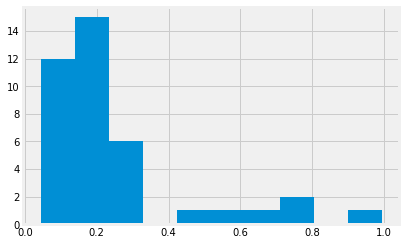

In [20]:
X_all = get_low_variance(X_all,0.05)